In [58]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import ishigami, ishigami_true_indices, linear
from shapley.plots import set_style_paper, plot_violin, matrix_plot

import time

%load_ext autoreload
%autoreload 2

%matplotlib inline
set_style_paper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
dim = 3
beta = [1., 1.]
model = lambda x: linear(x, beta)
model = ishigami
margins = [ot.Normal()]*dim
margins = [ot.Uniform(-np.pi, np.pi)]*dim
#margins = [ot.Normal(0, 1.), ot.Normal(0, 1.)]

In [83]:
n_theta = 30
max_budget = 100000
n_sample = int(max_budget/(2*dim))
n_boot = 1

thetas = np.linspace(-0.99, 0.99, n_theta, endpoint=True)
estimator = 'janon1'
indices_thetas = np.zeros((dim, n_theta))
for k, theta in enumerate(thetas):
    sigma = np.identity(dim)
    sigma[1, 0] = theta
    sigma[0, 1] = theta
    copula = ot.NormalCopula(ot.CorrelationMatrix(sigma))
    input_distribution = ot.ComposedDistribution(margins, copula)
    sobol = SobolIndices(input_distribution)
    if False:
        sobol.build_uncorrelated_mc_sample(model, n_sample)
    else:
        sobol.build_mc_sample(model, n_sample)
    first_indices_mc = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
    indices_thetas[:, k] = first_indices_mc.mean(axis=1)

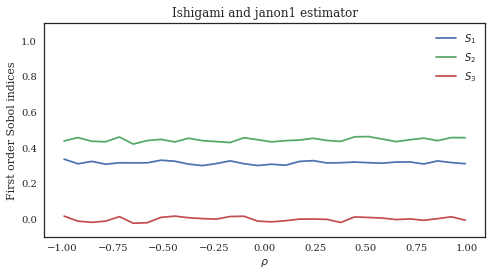

In [85]:
ylim = [-0.1, 1.1]
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(dim):
    ax.plot(thetas, indices_thetas[i, :], label="$S_%d$" % (i+1));
ax.set_ylim(ylim)
ax.set_xlabel('$\\rho$')
ax.set_ylabel('First order Sobol indices')
ax.legend(loc=0)
if model == ishigami:
    ax.set_title('Ishigami and %s estimator' % (estimator))
    fig.tight_layout()
    fig.savefig('./sobol_correlation_ishigami_%s.pdf' % (estimator))
else:
    ax.set_title('Additive Gaussian model and %s estimator' % (estimator))
    fig.tight_layout()
    fig.savefig('./sobol_correlation_gaussian_%s.pdf' % (estimator))